In [54]:
import gym
from gym import spaces
from qutip import *
from IPython.display import Image
from qutip.qip.operations import *
from qutip.qip.circuit import * 
import numpy as np
from qutip.qip.device import Processor
from qutip.qip.device import CircularSpinChain, LinearSpinChain
from qutip.qip.noise import RandomNoise
from qutip.operators import sigmaz, sigmay, sigmax, destroy
from qutip.states import basis
from qutip.metrics import fidelity
from qutip.qip.operations import rx, ry, rz, hadamard_transform
import networkx as nx

import CircuitUtils as cu
import CircutEmbedding as ce



In [66]:
class QubitHardwareEnv(gym.Env):
  """Custom Environment that follows gym interface"""
  metadata = {'render.modes': ['human']}

  def __init__(self, vert_len_grid, horizon_len_grid, width_circuit):    
    super(QubitHardwareEnv, self).__init__()
    self.width_of_circuit = width_of_circuit
    self.vert_len_grid = vert_len_grid
    self.horizon_len_grid = horizon_len_grid
    grid = nx.generators.lattice.grid_2d_graph(self.vert_len_grid,self.horizon_len_grid, create_using = nx.DiGraph)
    grid = ce.relabel(grid)
    adj_dict = {node:list(edges) for node,edges in dict(grid.adj).items()}
    
    self.pointer_pos = 0
    self.num_nodes = grid.number_of_nodes()

    

    # Define action and observation space
 
    #Will need the following actions:
    #Apply a hadamard, apply a swap, apply a cnot
    #When it applys a CNOT or SWAP it needs to identify which qubits it 
    #can apply gates to from current possition and choose one
    #Will have a pointer that applies a gate to the pointers location
    gates = 3 #Hadamard, CNOT, SWAP

    self.action_space = spaces.Dict({"pointer":Discrete(self.num_nodes), #spaces.Box(low=np.array([0, 0]), high=np.array([vert_len_grid, horizon_len_grid]),dtype=np.int16),
                                     "gates": Discrete(gates)})
    self.action_space = spaces.MultiDiscrete(grid.number_of_nodes(),gates)
    # Example for using image as input:
    self.observation_space = spaces.Box(low=np.array([0,self.horizon_len_grid]), high=np.array([0,self.vert_len_grid]), dtype=np.uint8)
    #self.observation_space = spaces.MultiDiscete([grid.number_of_nodes(), grid.number_of_edges()])

  def step(self, action):
    self._take_action(action)
    
    pass
    # Execute one time step within the environment

  def reset(self):
    pass
    # Reset the state of the environment to an initial state
  def render(self, mode='human', close=False):
    pass
    # Render the environment to the screen
  def _take_action(self, action):
    pass
    

In [73]:
action_space = spaces.Box(low=np.array([0, 0]), high=np.array([2, 2]),dtype=np.int16)

In [79]:
action_space.sample()

array([0, 1], dtype=int16)

In [72]:
print(action_space)

Box(2,)


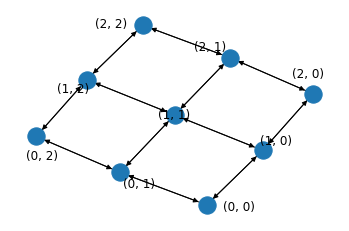

In [65]:
grid = nx.generators.lattice.grid_2d_graph(3,3, create_using = nx.DiGraph)
#grid =ce.relabel_grid(grid)
nx.draw_networkx_labels(grid, pos=nx.spring_layout(grid))
nx.draw(grid)
    

In [61]:
grid.adjacency()
for element in grid.adjacency():
    print(element)

((0, 0), {(0, 1): {}, (1, 0): {}})
((0, 1), {(0, 0): {}, (0, 2): {}, (1, 1): {}})
((0, 2), {(0, 1): {}, (1, 2): {}})
((1, 0), {(0, 0): {}, (1, 1): {}, (2, 0): {}})
((1, 1), {(0, 1): {}, (1, 0): {}, (1, 2): {}, (2, 1): {}})
((1, 2), {(0, 2): {}, (1, 1): {}, (2, 2): {}})
((2, 0), {(1, 0): {}, (2, 1): {}})
((2, 1), {(1, 1): {}, (2, 0): {}, (2, 2): {}})
((2, 2), {(1, 2): {}, (2, 1): {}})


In [ ]:
class AdjacencyEnv(gym.Env):
  def __init__(self, node, adjacency_dict,t1_times_dict):
    super(AdjacencyEnv, self).__init__()
    self.action_space = Discrete(len(adjacency_dict[node]))
    self.observation_space = Discrete(len(t1_times_dict))
  def _next_observation():
    obs = 